In [41]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, HerbertTokenizer, BatchEncoding

import gc
from sklearn.neighbors import KNeighborsClassifier

import scipy
from scipy import spatial

from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

In [ ]:
# # https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch
# #try add l1 tregularisation

# loss = loss_fn(outputs, labels)
# l1_lambda = 0.001
# l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())

# loss = loss + l1_lambda * l1_norm

In [42]:
torch.manual_seed(111)
np.random.seed(111)
random.seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()
    
device.type

'cuda'

## Get data

In [43]:
df_topics = pd.read_csv('../datasets/ready2use/topics.csv', index_col=0)

In [44]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

df = df.copy()[['assestment', 'text_clean']][df.index.isin(df_topics.index)].reset_index(drop=True)

In [45]:
with open('../datasets/ready2use/style_emb_pl.npy', 'rb') as f:
    emb_style = np.load(f)

In [46]:
embeddings_table = pd.read_csv('../datasets/ready2use/embeddings_pl_herbert.csv', sep=",", header=None).values
embeddings_table.shape

(6541, 1024)

In [47]:
with open('../datasets/ready2use/embeddings_pl_herbert_aug.npy', 'rb') as f:
    embeddings_table_aug = np.load(f)

embeddings_table_aug.shape

(65410, 1024)

In [48]:
# embeddings_table = np.concatenate([embeddings_table, emb_style],1)
# embeddings_table.shape

In [49]:
# X_pos = pd.read_csv('../datasets/ready2use/pos_pl_dataset.csv', sep=';')
# del X_pos['assestment']
# print( X_pos.shape )

# corr_score = []
# for c in X_pos.columns:
#     min_v = X_pos[c].values[train_index].min()
#     max_v = X_pos[c].values[train_index].max()

#     if min_v < max_v:
#         r = scipy.stats.pearsonr(X_pos[c].values[train_index], y_train)[0]
#         if ~np.isnan(r):
#             corr_score.append(r)
#         else:
#             corr_score.append(0)
#     else:
#         corr_score.append(0)
        
        
# embeddings_table = X_pos.values[ :, np.argsort(corr_score)[-1024:] ]
# embeddings_table.shape

## Kfold

In [50]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv = df_topics.index[ ~np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, val_cv, test_cv])
    cv_fold_i.append( [train_cv_i, val_cv_i, test_cv_i])

In [51]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_index, val_index = train_test_split(train_index, test_size=1/9, shuffle=True)
    train_cv = df_topics.iloc[ train_index, : ].index.values
    val_cv = df_topics.iloc[ val_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    val_cv_i = df_topics.reset_index().iloc[ val_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, val_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, val_cv_i, test_cv_i])

## Train

## TripletLoss

In [52]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [53]:
class TripletLossVector():
    def __init__(self, margin=1.0):
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def get_loss(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        
        return losses

## Visualise test with UMAP

In [54]:
train_index, val_index, test_index = cv_Kfold_i[np.random.randint(10)]
y_train = df['assestment'].values[train_index]
y_val = df['assestment'].values[val_index]
y_test = df['assestment'].values[test_index]

unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

scaler = StandardScaler().fit(embeddings_table[train_index])

[[   0 2764]
 [   1 2468]]


In [55]:
reducer = umap.UMAP()
umap_train = reducer.fit_transform(scaler.transform(embeddings_table[train_index]), y=y_train)
umap_val = reducer.transform(scaler.transform(embeddings_table[val_index]))
umap_test = reducer.transform(scaler.transform(embeddings_table[test_index]))

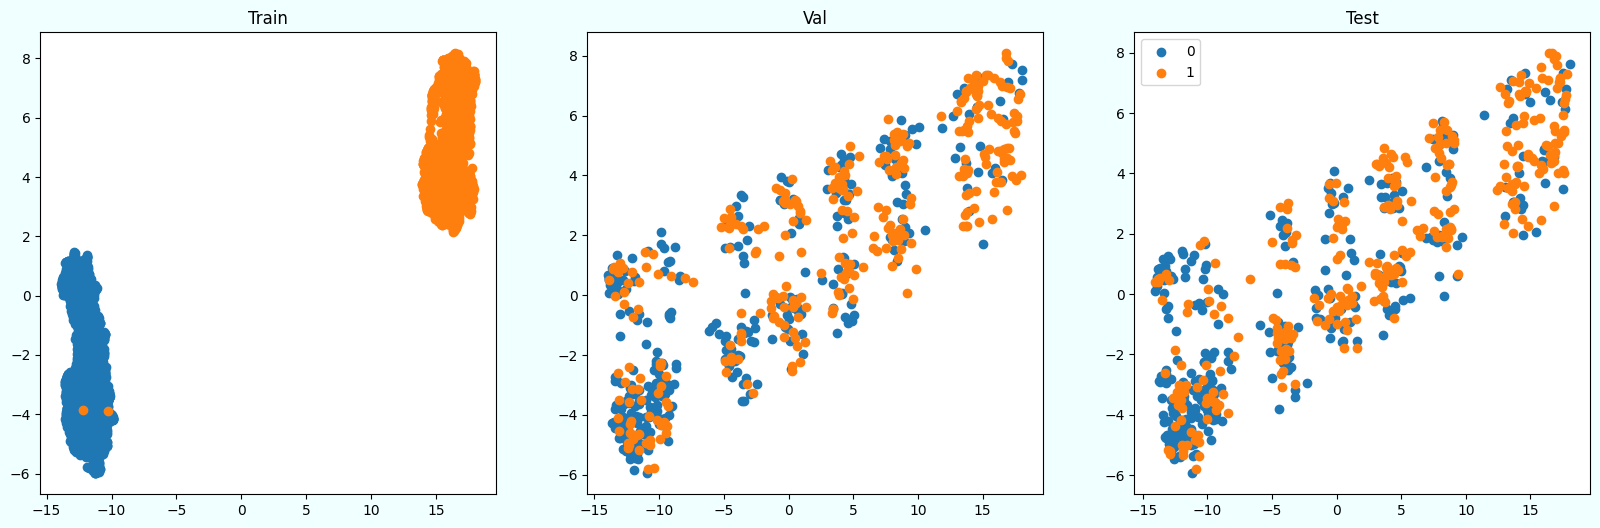

In [56]:
plt.figure(figsize=(20, 6), facecolor="azure")

plt.subplot(1, 3, 1)
for label in np.unique(y_train):
    tmp = umap_train[y_train==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Train')
    
plt.subplot(1, 3, 2)
for label in np.unique(y_val):
    tmp = umap_val[y_val==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Val')

plt.subplot(1, 3, 3)
for label in np.unique(y_test):
    tmp = umap_test[y_test==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Test')

plt.legend()
plt.show()

## Dataloader

In [57]:
class FakeNews(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use, factor=1):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.repeat( [np.arange(index_to_use.shape[0])], factor, axis=0).reshape(-1)
        
        self.idx = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx): 
        item = self.index[idx]
                
        anchor_label = self.labels[item]

        positive_list = self.idx[self.idx!=item][self.labels[self.idx!=item]==anchor_label]

        positive_item = random.choice(positive_list)
        
        negative_list = self.idx[self.idx!=item][self.labels[self.idx!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        
        anchor_claim = self.emb[item].astype(np.float32)
        positive_claim = self.emb[positive_item].astype(np.float32)
        negative_claim = self.emb[negative_item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, positive_claim, negative_claim, anchor_label

class FakeNewsLabel(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.emb)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]
        
        anchor_claim = self.emb[item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, anchor_label

In [58]:
embedding_dims = 20
batch_size = 512
epochs = 200
n_workers = 8

In [59]:
def prepare_loaders(emb_tab=embeddings_table, 
                    emb_tab_train=embeddings_table_aug,
                    y_column=df['assestment'].values, 
                    batch_size=batch_size,
                    index_llist = [train_index, val_index, test_index],
                    sizes= [10,3],
                    n_workers=n_workers
                   ):
    train_index, val_index, test_index = index_llist
    
    train_index_more = np.concatenate([train_index.reshape(-1, 1)*10+i for i in range(10)], 1).reshape(-1)
    
    train_ds = FakeNews(emb_tab_train, np.repeat(y_column, 10), train_index_more, 1)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)

    train_ds_label = FakeNewsLabel(emb_tab, y_column, train_index)
    train_loader_label = DataLoader(train_ds_label, batch_size=batch_size, shuffle=True, num_workers=n_workers)

    val_ds = FakeNews(emb_tab, y_column, val_index, 1)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)

    test_ds = FakeNewsLabel(emb_tab, y_column, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=n_workers)
    
    return train_loader, train_loader_label, val_loader, test_loader

In [60]:
train_loader, train_loader_label, val_loader, test_loader = prepare_loaders(
    emb_tab=embeddings_table, 
    emb_tab_train=embeddings_table_aug,
    y_column=df['assestment'].values, 
    batch_size=batch_size,
    index_llist = [train_index, val_index, test_index],
    sizes= [10,3],
    n_workers=n_workers
)

## Define Net

In [61]:
class Network(nn.Module):
    def __init__(self, emb_dim=128, in_shape=1024):
        super(Network, self).__init__()
        
        self.in_shape = in_shape
        
        self.fc = nn.Sequential(
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.5),
            
            nn.Linear(in_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, emb_dim)
            
#             nn.Linear(1024, emb_dim),
#             nn.BatchNorm1d(emb_dim),
#             nn.ReLU(),
#             nn.Dropout(0.5),
        )
        
    def forward(self, x):
        x = x.view(-1, self.in_shape)
        x = self.fc(x)
        return x

In [62]:
model = Network(embedding_dims,embeddings_table.shape[1])
# model = torch.nn.DataParallel(model)
# model = torch.jit.script(model).to(device)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# criterion = torch.jit.script(TripletLoss())
criterion = TripletLoss()

## Training loop

In [63]:
def train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=1000,
    n_print=100,
    if_norm=False,
    optimizer=optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5),
    criterion=TripletLoss(),
    n_model=0,
    model_name='model_X.pt'
):
    val_prev = np.inf
    
    model.train()
    for epoch in tqdm(range(epochs), desc="Epochs"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
            positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
            negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)
            
            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())
        model.eval()
        
        val_loss = []
        for anchor_claim, positive_claim, negative_claim, _ in val_loader:
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
            positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
            negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)

            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            val_loss.append(loss.cpu().detach().numpy())

        model.train()
        
        if np.mean(val_loss) < val_prev:
            val_prev = np.mean(val_loss)
            torch.save(model, f'models/{model_name}')

        if epoch%n_print == 0:
            print(f"{n_model} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
                  f" Val Loss: {np.mean(val_loss):.4f} Best Val loss {val_prev:.4f}")


In [64]:
# train_loop(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=1000,
#     n_print=100,
#     if_norm=False,
#     optimizer=optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5),
#     criterion=TripletLoss(),
#     n_model=0,
#     model_name='model_XXX.pt'
# )

In [51]:
# # train_loss_out = []
# # val_loss_out = []

# val_prev = np.inf

# if_norm = False
# loss_vec = TripletLossVector()
# k_top = None

# model.train()
# for epoch in tqdm(range(epochs), desc="Epochs"):
#     running_loss = []
#     for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
#         anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
#         positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
#         negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)
        
#         if k_top:
#             losses_order = torch.argsort(
#                 loss_vec.get_loss(anchor_claim, positive_claim, negative_claim),
#                 descending=True
#             )[-k_top:]

#             anchor_claim = anchor_claim[losses_order]
#             positive_claim = positive_claim[losses_order]
#             negative_claim = negative_claim[losses_order]
                
#         optimizer.zero_grad()
#         anchor_out = model(anchor_claim)
#         positive_out = model(positive_claim)
#         negative_out = model(negative_claim)
        
#         loss = criterion(anchor_out, positive_out, negative_out)
#         loss.backward()
#         optimizer.step()
        
#         running_loss.append(loss.cpu().detach().numpy())
#     model.eval()
    
#     val_loss = []
#     for anchor_claim, positive_claim, negative_claim, _ in val_loader:
#         anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
#         positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
#         negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)

#         anchor_out = model(anchor_claim)
#         positive_out = model(positive_claim)
#         negative_out = model(negative_claim)
        
#         loss = criterion(anchor_out, positive_out, negative_out)
#         val_loss.append(loss.cpu().detach().numpy())
    
#     model.train()
    
# #     train_loss_out.append(np.mean(running_loss))
# #     val_loss_out.append(np.mean(val_loss))
    
#     if np.mean(val_loss) < val_prev:
# #         print(epoch, f'saved {np.mean(val_loss):.4f} < {val_prev:.4f}')
#         val_prev = np.mean(val_loss)
#         torch.save(model, 'models/model_03.pt')
        
#     if epoch%10 == 0:
#         print(f"Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
#               f" Val Loss: {np.mean(val_loss):.4f} Best Val loss {val_prev:.4f}")
        
# #     if epoch == 20:
# #         for param_group in optimizer.param_groups:
# #             param_group['lr'] = 0.001
# #     elif epoch == 50:
# #         for param_group in optimizer.param_groups:
# #             param_group['lr'] = 0.0001
# #     elif epoch == 300:
# #         for param_group in optimizer.param_groups:
# #             param_group['lr'] = 0.00001

In [52]:
model = torch.load('models/model_XX.pt')

In [53]:
train_results = []
labels = []

if_norm = False

model.eval()
with torch.no_grad():
    for anchor_claim, label in tqdm(train_loader_label):
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        
        train_results.append(model(anchor_claim).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results) 
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/11 [00:00<?, ?it/s]

(5232, 20)

In [54]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for anchor_claim, label in tqdm(test_loader):
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        
        test_results.append(model(anchor_claim).cpu().numpy())
        test_labels.append(label)
        
test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)
test_results.shape

  0%|          | 0/2 [00:00<?, ?it/s]

(654, 20)

In [55]:
reducer_nn = umap.UMAP()
scaler_nn = StandardScaler().fit(train_results)

umap_nn_train = train_results if True else reducer_nn.fit_transform(train_results)
umap_nn_test = test_results if True else reducer_nn.transform(test_results)

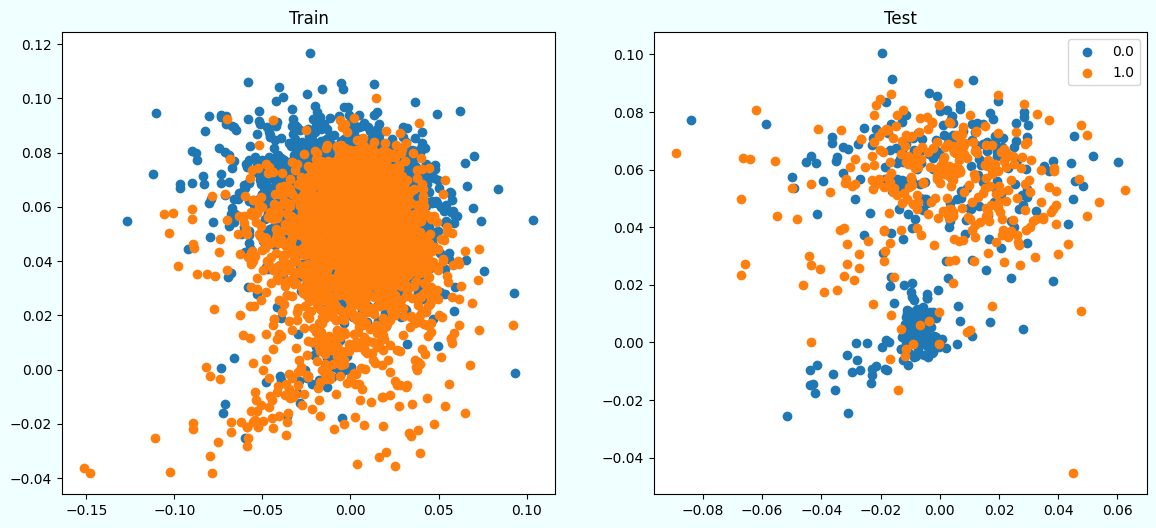

In [56]:
plt.figure(figsize=(14, 6), facecolor="azure")

plt.subplot(1, 2, 1)
for label in np.unique(labels):
    tmp = umap_nn_train[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Train')

plt.subplot(1, 2, 2)
for label in np.unique(test_labels):
    tmp = umap_nn_test[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Test')

plt.legend()
plt.show()

In [57]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [58]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


y_train_t = labels
X_train_t = train_results
y_test_t = test_labels
X_test_t = test_results

clf_lr_1.fit(X_train_t, y_train_t)

y_pred = clf_lr_1.predict(X_test_t)

results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

metrics = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

In [59]:
confusion_matrix(y_test_t, y_pred)

array([[237, 100],
       [ 98, 219]])

In [60]:
metrics

{'Accuracy': array([0.69724771]), 'F1 Score': array([0.68867925])}

# Test using CV

In [65]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 512
epochs = 1000
n_workers = 8

for j, (train_index, val_index, test_index) in enumerate(cv_fold_i):
    train_loader, train_loader_label, val_loader, test_loader = prepare_loaders(
        emb_tab=embeddings_table, 
        emb_tab_train=embeddings_table_aug,
        y_column=df['assestment'].values, 
        batch_size=batch_size,
        index_llist = [train_index, val_index, test_index],
        sizes= [10,3],
        n_workers=n_workers,
        n_model=j
    )
    
    model = Network(embedding_dims)
    model = model.to(device)
    
    if_norm = False 
    
    train_loop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=1000,
        n_print=100,
        if_norm=if_norm,
        optimizer=optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5),
        criterion=TripletLoss(),
        n_model=0,
        model_name='model_X.pt'
    )
    
    model = torch.load('models/model_X.pt')
    
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for anchor_claim, label in tqdm(train_loader_label):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)

    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)
    train_results.shape

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for anchor_claim, label in tqdm(test_loader):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)

    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)
    test_results.shape

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 6.5345;  Val Loss: 1.2993 Best Val loss 1.2993
0 Epoch: 101/1000 - Train Loss: 0.3581;  Val Loss: 0.5225 Best Val loss 0.5225
0 Epoch: 201/1000 - Train Loss: 0.0521;  Val Loss: 0.4065 Best Val loss 0.4024
0 Epoch: 301/1000 - Train Loss: 0.0261;  Val Loss: 0.4140 Best Val loss 0.3967
0 Epoch: 401/1000 - Train Loss: 0.0191;  Val Loss: 0.4168 Best Val loss 0.3605
0 Epoch: 501/1000 - Train Loss: 0.0148;  Val Loss: 0.4195 Best Val loss 0.3586
0 Epoch: 601/1000 - Train Loss: 0.0131;  Val Loss: 0.4066 Best Val loss 0.3586
0 Epoch: 701/1000 - Train Loss: 0.0121;  Val Loss: 0.4092 Best Val loss 0.3419
0 Epoch: 801/1000 - Train Loss: 0.0106;  Val Loss: 0.3746 Best Val loss 0.3360
0 Epoch: 901/1000 - Train Loss: 0.0094;  Val Loss: 0.4010 Best Val loss 0.3360


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 6.2847;  Val Loss: 1.2688 Best Val loss 1.2688
0 Epoch: 101/1000 - Train Loss: 0.3520;  Val Loss: 0.6069 Best Val loss 0.5931
0 Epoch: 201/1000 - Train Loss: 0.0528;  Val Loss: 0.5675 Best Val loss 0.4764
0 Epoch: 301/1000 - Train Loss: 0.0276;  Val Loss: 0.5088 Best Val loss 0.4647
0 Epoch: 401/1000 - Train Loss: 0.0208;  Val Loss: 0.5275 Best Val loss 0.4647
0 Epoch: 501/1000 - Train Loss: 0.0187;  Val Loss: 0.5472 Best Val loss 0.4647
0 Epoch: 601/1000 - Train Loss: 0.0142;  Val Loss: 0.5377 Best Val loss 0.4647
0 Epoch: 701/1000 - Train Loss: 0.0119;  Val Loss: 0.5587 Best Val loss 0.4647
0 Epoch: 801/1000 - Train Loss: 0.0105;  Val Loss: 0.5708 Best Val loss 0.4647
0 Epoch: 901/1000 - Train Loss: 0.0107;  Val Loss: 0.5488 Best Val loss 0.4647


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 6.5368;  Val Loss: 1.2520 Best Val loss 1.2520
0 Epoch: 101/1000 - Train Loss: 0.3970;  Val Loss: 0.9334 Best Val loss 0.9150
0 Epoch: 201/1000 - Train Loss: 0.0589;  Val Loss: 0.7416 Best Val loss 0.7345
0 Epoch: 301/1000 - Train Loss: 0.0330;  Val Loss: 0.7322 Best Val loss 0.7100
0 Epoch: 401/1000 - Train Loss: 0.0248;  Val Loss: 0.7015 Best Val loss 0.6484
0 Epoch: 501/1000 - Train Loss: 0.0199;  Val Loss: 0.7099 Best Val loss 0.6484


KeyboardInterrupt: 

### Get use best models

In [51]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 512
epochs = 1000
n_workers = 8

for j, (train_index, val_index, test_index) in enumerate(cv_Kfold_i):
    train_loader, train_loader_label, val_loader, test_loader = prepare_loaders(
        emb_tab=embeddings_table, 
        emb_tab_train=embeddings_table_aug,
        y_column=df['assestment'].values, 
        batch_size=batch_size,
        index_llist = [train_index, val_index, test_index],
        sizes= [10,3],
        n_workers=n_workers
    )
    
    model = Network(embedding_dims)
    model = model.to(device)

    train_loop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=1000,
        n_print=100,
        if_norm=False,
        optimizer=optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5),
        criterion=TripletLoss(),
        n_model=0,
        model_name='model_X.pt'
    )
    
    model = torch.load('models/model_X.pt')
    
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for anchor_claim, label in tqdm(train_loader_label):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)

    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)
    train_results.shape

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for anchor_claim, label in tqdm(test_loader):
            anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)

    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)
    test_results.shape

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.6703;  Val Loss: 1.2954 Best Val loss 1.2954
0 Epoch: 101/1000 - Train Loss: 0.0166;  Val Loss: 0.9712 Best Val loss 0.9415
0 Epoch: 201/1000 - Train Loss: 0.0080;  Val Loss: 0.9636 Best Val loss 0.9397
0 Epoch: 301/1000 - Train Loss: 0.0058;  Val Loss: 0.9690 Best Val loss 0.9238
0 Epoch: 401/1000 - Train Loss: 0.0056;  Val Loss: 0.9351 Best Val loss 0.9118
0 Epoch: 501/1000 - Train Loss: 0.0040;  Val Loss: 0.9093 Best Val loss 0.9019
0 Epoch: 601/1000 - Train Loss: 0.0041;  Val Loss: 0.9109 Best Val loss 0.8879
0 Epoch: 701/1000 - Train Loss: 0.0022;  Val Loss: 1.0005 Best Val loss 0.8863
0 Epoch: 801/1000 - Train Loss: 0.0030;  Val Loss: 1.0027 Best Val loss 0.8863
0 Epoch: 901/1000 - Train Loss: 0.0026;  Val Loss: 0.9688 Best Val loss 0.8863


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.6029;  Val Loss: 1.4145 Best Val loss 1.4145
0 Epoch: 101/1000 - Train Loss: 0.0243;  Val Loss: 0.9719 Best Val loss 0.9512
0 Epoch: 201/1000 - Train Loss: 0.0066;  Val Loss: 0.9553 Best Val loss 0.9315
0 Epoch: 301/1000 - Train Loss: 0.0067;  Val Loss: 0.9424 Best Val loss 0.9078
0 Epoch: 401/1000 - Train Loss: 0.0053;  Val Loss: 0.8994 Best Val loss 0.8994
0 Epoch: 501/1000 - Train Loss: 0.0036;  Val Loss: 0.9018 Best Val loss 0.8771
0 Epoch: 601/1000 - Train Loss: 0.0041;  Val Loss: 0.9445 Best Val loss 0.8648
0 Epoch: 701/1000 - Train Loss: 0.0045;  Val Loss: 0.9446 Best Val loss 0.8648
0 Epoch: 801/1000 - Train Loss: 0.0034;  Val Loss: 0.9362 Best Val loss 0.8648
0 Epoch: 901/1000 - Train Loss: 0.0041;  Val Loss: 0.9752 Best Val loss 0.8648


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.4580;  Val Loss: 1.4915 Best Val loss 1.4915
0 Epoch: 101/1000 - Train Loss: 0.0169;  Val Loss: 0.9889 Best Val loss 0.9566
0 Epoch: 201/1000 - Train Loss: 0.0093;  Val Loss: 0.9911 Best Val loss 0.9566
0 Epoch: 301/1000 - Train Loss: 0.0057;  Val Loss: 0.9576 Best Val loss 0.9488
0 Epoch: 401/1000 - Train Loss: 0.0052;  Val Loss: 0.9575 Best Val loss 0.9406
0 Epoch: 501/1000 - Train Loss: 0.0058;  Val Loss: 0.9392 Best Val loss 0.9144
0 Epoch: 601/1000 - Train Loss: 0.0033;  Val Loss: 0.9463 Best Val loss 0.9142
0 Epoch: 701/1000 - Train Loss: 0.0037;  Val Loss: 0.9263 Best Val loss 0.9142
0 Epoch: 801/1000 - Train Loss: 0.0028;  Val Loss: 0.9612 Best Val loss 0.9100
0 Epoch: 901/1000 - Train Loss: 0.0037;  Val Loss: 0.9971 Best Val loss 0.9100


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.4317;  Val Loss: 1.3873 Best Val loss 1.3873
0 Epoch: 101/1000 - Train Loss: 0.0163;  Val Loss: 0.9753 Best Val loss 0.9598
0 Epoch: 201/1000 - Train Loss: 0.0095;  Val Loss: 0.9805 Best Val loss 0.9593
0 Epoch: 301/1000 - Train Loss: 0.0054;  Val Loss: 0.9413 Best Val loss 0.9354
0 Epoch: 401/1000 - Train Loss: 0.0061;  Val Loss: 0.9942 Best Val loss 0.9169
0 Epoch: 501/1000 - Train Loss: 0.0045;  Val Loss: 0.9639 Best Val loss 0.9087
0 Epoch: 601/1000 - Train Loss: 0.0037;  Val Loss: 0.9829 Best Val loss 0.9087
0 Epoch: 701/1000 - Train Loss: 0.0045;  Val Loss: 0.9351 Best Val loss 0.9068
0 Epoch: 801/1000 - Train Loss: 0.0035;  Val Loss: 0.9813 Best Val loss 0.9068
0 Epoch: 901/1000 - Train Loss: 0.0029;  Val Loss: 1.0686 Best Val loss 0.9068


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.5111;  Val Loss: 1.3362 Best Val loss 1.3362
0 Epoch: 101/1000 - Train Loss: 0.0177;  Val Loss: 0.9846 Best Val loss 0.9476
0 Epoch: 201/1000 - Train Loss: 0.0061;  Val Loss: 0.9783 Best Val loss 0.9476
0 Epoch: 301/1000 - Train Loss: 0.0047;  Val Loss: 0.9614 Best Val loss 0.9428
0 Epoch: 401/1000 - Train Loss: 0.0029;  Val Loss: 0.9573 Best Val loss 0.9182
0 Epoch: 501/1000 - Train Loss: 0.0026;  Val Loss: 0.9222 Best Val loss 0.9030
0 Epoch: 601/1000 - Train Loss: 0.0028;  Val Loss: 0.9609 Best Val loss 0.8930
0 Epoch: 701/1000 - Train Loss: 0.0041;  Val Loss: 1.0528 Best Val loss 0.8930
0 Epoch: 801/1000 - Train Loss: 0.0022;  Val Loss: 1.0297 Best Val loss 0.8930
0 Epoch: 901/1000 - Train Loss: 0.0017;  Val Loss: 1.0161 Best Val loss 0.8930


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.2926;  Val Loss: 1.2223 Best Val loss 1.2223
0 Epoch: 101/1000 - Train Loss: 0.0156;  Val Loss: 0.9898 Best Val loss 0.9606
0 Epoch: 201/1000 - Train Loss: 0.0066;  Val Loss: 0.9831 Best Val loss 0.9606
0 Epoch: 301/1000 - Train Loss: 0.0044;  Val Loss: 0.9615 Best Val loss 0.9479
0 Epoch: 401/1000 - Train Loss: 0.0064;  Val Loss: 0.9745 Best Val loss 0.9370
0 Epoch: 501/1000 - Train Loss: 0.0048;  Val Loss: 0.9422 Best Val loss 0.9205
0 Epoch: 601/1000 - Train Loss: 0.0048;  Val Loss: 0.9872 Best Val loss 0.9205
0 Epoch: 701/1000 - Train Loss: 0.0027;  Val Loss: 0.9954 Best Val loss 0.9205
0 Epoch: 801/1000 - Train Loss: 0.0030;  Val Loss: 0.9960 Best Val loss 0.9205
0 Epoch: 901/1000 - Train Loss: 0.0035;  Val Loss: 1.0238 Best Val loss 0.9205


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.6293;  Val Loss: 1.4478 Best Val loss 1.4478
0 Epoch: 101/1000 - Train Loss: 0.0191;  Val Loss: 0.9864 Best Val loss 0.9488
0 Epoch: 201/1000 - Train Loss: 0.0081;  Val Loss: 0.9534 Best Val loss 0.9488
0 Epoch: 301/1000 - Train Loss: 0.0055;  Val Loss: 0.9226 Best Val loss 0.9226
0 Epoch: 401/1000 - Train Loss: 0.0044;  Val Loss: 0.9178 Best Val loss 0.9032
0 Epoch: 501/1000 - Train Loss: 0.0032;  Val Loss: 0.9677 Best Val loss 0.9032
0 Epoch: 601/1000 - Train Loss: 0.0035;  Val Loss: 0.9839 Best Val loss 0.9032
0 Epoch: 701/1000 - Train Loss: 0.0029;  Val Loss: 0.9293 Best Val loss 0.9032
0 Epoch: 801/1000 - Train Loss: 0.0026;  Val Loss: 1.0252 Best Val loss 0.9032
0 Epoch: 901/1000 - Train Loss: 0.0042;  Val Loss: 1.1247 Best Val loss 0.9032


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.4919;  Val Loss: 1.3163 Best Val loss 1.3163
0 Epoch: 101/1000 - Train Loss: 0.0189;  Val Loss: 0.9858 Best Val loss 0.9451
0 Epoch: 201/1000 - Train Loss: 0.0062;  Val Loss: 0.9894 Best Val loss 0.9451
0 Epoch: 301/1000 - Train Loss: 0.0068;  Val Loss: 0.9660 Best Val loss 0.9446
0 Epoch: 401/1000 - Train Loss: 0.0038;  Val Loss: 0.9460 Best Val loss 0.9207
0 Epoch: 501/1000 - Train Loss: 0.0044;  Val Loss: 0.9012 Best Val loss 0.9012
0 Epoch: 601/1000 - Train Loss: 0.0039;  Val Loss: 0.9217 Best Val loss 0.8980
0 Epoch: 701/1000 - Train Loss: 0.0028;  Val Loss: 0.9707 Best Val loss 0.8973
0 Epoch: 801/1000 - Train Loss: 0.0045;  Val Loss: 0.9580 Best Val loss 0.8973
0 Epoch: 901/1000 - Train Loss: 0.0030;  Val Loss: 1.0051 Best Val loss 0.8973


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.4186;  Val Loss: 1.3113 Best Val loss 1.3113
0 Epoch: 101/1000 - Train Loss: 0.0204;  Val Loss: 0.9950 Best Val loss 0.9690
0 Epoch: 201/1000 - Train Loss: 0.0091;  Val Loss: 0.9875 Best Val loss 0.9690
0 Epoch: 301/1000 - Train Loss: 0.0079;  Val Loss: 0.9773 Best Val loss 0.9599
0 Epoch: 401/1000 - Train Loss: 0.0070;  Val Loss: 0.9179 Best Val loss 0.9179
0 Epoch: 501/1000 - Train Loss: 0.0049;  Val Loss: 0.9714 Best Val loss 0.9179
0 Epoch: 601/1000 - Train Loss: 0.0042;  Val Loss: 0.9963 Best Val loss 0.9179
0 Epoch: 701/1000 - Train Loss: 0.0044;  Val Loss: 0.9556 Best Val loss 0.9156
0 Epoch: 801/1000 - Train Loss: 0.0050;  Val Loss: 0.9697 Best Val loss 0.9156
0 Epoch: 901/1000 - Train Loss: 0.0035;  Val Loss: 0.9961 Best Val loss 0.9156


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.5356;  Val Loss: 1.4370 Best Val loss 1.4370
0 Epoch: 101/1000 - Train Loss: 0.0222;  Val Loss: 0.9846 Best Val loss 0.9434
0 Epoch: 201/1000 - Train Loss: 0.0086;  Val Loss: 0.9872 Best Val loss 0.9434
0 Epoch: 301/1000 - Train Loss: 0.0058;  Val Loss: 0.9804 Best Val loss 0.9434
0 Epoch: 401/1000 - Train Loss: 0.0051;  Val Loss: 0.9713 Best Val loss 0.9434
0 Epoch: 501/1000 - Train Loss: 0.0048;  Val Loss: 0.9620 Best Val loss 0.9259
0 Epoch: 601/1000 - Train Loss: 0.0027;  Val Loss: 0.9535 Best Val loss 0.9259
0 Epoch: 701/1000 - Train Loss: 0.0037;  Val Loss: 0.9527 Best Val loss 0.9259
0 Epoch: 801/1000 - Train Loss: 0.0041;  Val Loss: 0.9523 Best Val loss 0.9228
0 Epoch: 901/1000 - Train Loss: 0.0035;  Val Loss: 0.9519 Best Val loss 0.9228


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

triplet loss lr C1 Accuracy 0.691+-0.062 F1 Score 0.677+-0.041  0.691+-0.062 | 0.677+-0.041
